<a href="https://colab.research.google.com/github/TejeswarReddyMuli/Pneumonia-Detection/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os

In [2]:
labels = ['PNEUMONIA','NORMAL']
img_resize = 150

def get_data(dir):
  data = []
  for label in labels:
    path = os.path.join(dir, label)
    class_num = labels.index(label)

    for img in os.listdir(path):
      try:
        if img.endswith('jpeg'):
          img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
          resized_arr = cv2.resize(img_arr, (img_resize, img_resize))
          data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data,dtype= 'object')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [5]:
base_dir = os.path.join(path, 'chest_xray') # change if needed
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [6]:
train = get_data(train_dir)
test = get_data(test_dir)
val = get_data(val_dir)

Data Visualization and Preprocessing

<Axes: xlabel='count'>

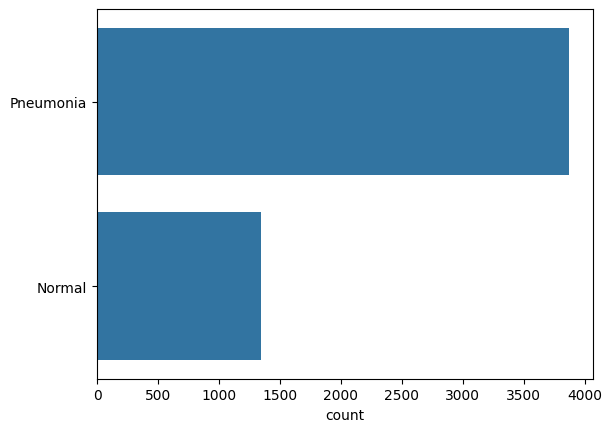

In [7]:
l = []
for i in train:
  if (i[1] == 0):
    l.append('Pneumonia')
  else:
    l.append('Normal')

sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

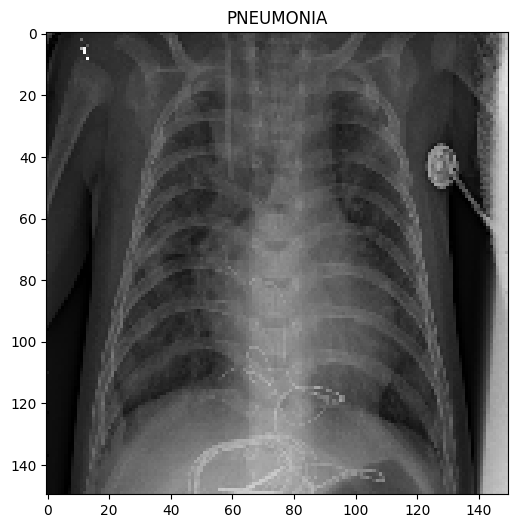

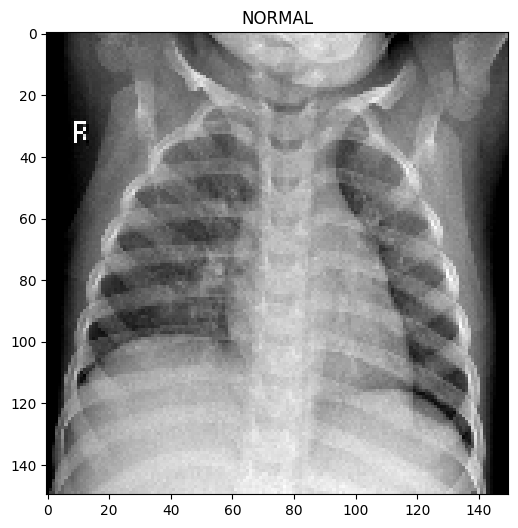

In [8]:
plt.figure(figsize=(6,6))

plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(6,6))

plt.imshow(train[-11][0], cmap='gray')
plt.title(labels[train[-11][1]])

In [9]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feat, label in train:
  x_train.append(feat)
  y_train.append(label)

for feat,label in val:
  x_val.append(feat)
  y_val.append(label)

for feat, label in test:
  x_test.append(feat)
  y_test.append(label)

In [10]:
#Normalize the data
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [11]:
x_train

array([[[0.29411765, 0.28235294, 0.12156863, ..., 0.50196078,
         0.65098039, 0.74509804],
        [0.23529412, 0.19607843, 0.        , ..., 0.49803922,
         0.67058824, 0.76862745],
        [0.21176471, 0.03137255, 0.01568627, ..., 0.43921569,
         0.60784314, 0.74901961],
        ...,
        [0.05098039, 0.05098039, 0.05098039, ..., 0.74509804,
         0.75294118, 0.76470588],
        [0.05098039, 0.04705882, 0.05098039, ..., 0.74509804,
         0.76862745, 0.77254902],
        [0.05098039, 0.04705882, 0.05098039, ..., 0.74509804,
         0.75686275, 0.77254902]],

       [[0.00784314, 0.03529412, 0.12941176, ..., 0.20392157,
         0.20392157, 0.17254902],
        [0.00392157, 0.03921569, 0.11764706, ..., 0.20392157,
         0.20784314, 0.16470588],
        [0.00392157, 0.03137255, 0.1254902 , ..., 0.19215686,
         0.41960784, 0.16470588],
        ...,
        [0.        , 0.        , 0.        , ..., 0.98823529,
         0.00392157, 0.02352941],
        [0.0

In [12]:
x_train = x_train.reshape(-1,img_resize, img_resize,1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1,img_resize,img_resize,1)
y_val = np.array(y_val)


x_test = x_test.reshape(-1,img_resize,img_resize,1)
y_test = np.array(y_test)

In [13]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(x_train)

Training the model

In [14]:
model = Sequential()
model.add(Conv2D(32,(3,3), strides =1, padding='same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3), strides =1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(128,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(256,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy']) #rmsprop
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.000001)

In [16]:
history = model.fit(x_train,y_train,batch_size=32,epochs=18,
                    validation_data=datagen.flow(x_val,y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8464 - loss: 0.7561

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.8467 - loss: 0.7538 - val_accuracy: 0.5000 - val_loss: 60.3170 - learning_rate: 0.0010
Epoch 2/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9547 - loss: 0.1273 - val_accuracy: 0.5000 - val_loss: 39.9754 - learning_rate: 0.0010
Epoch 3/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9682 - loss: 0.0989
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9682 - loss: 0.0989 - val_accuracy: 0.5000 - val_loss: 53.8389 - learning_rate: 0.0010
Epoch 4/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9855 - loss: 0.0414 - val_accuracy: 0.5000 - val_loss: 14.8685 - learning_rate: 3.0000e-04
Epoch 5/18
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9890 - loss: 0.0302
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9890 - loss: 0.0302

In [17]:
model.evaluate(x_test,y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9244 - loss: 0.8106


[2.815509796142578, 0.7419871687889099]

In [18]:
print(f"Loss of the model is {model.evaluate(x_test,y_test)[0]}")
print(f"Accuracy of the model is {model.evaluate(x_test,y_test)[1]*100} %")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9244 - loss: 0.8106
Loss of the model is 2.815509796142578
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9244 - loss: 0.8106
Accuracy of the model is 74.19871687889099 %


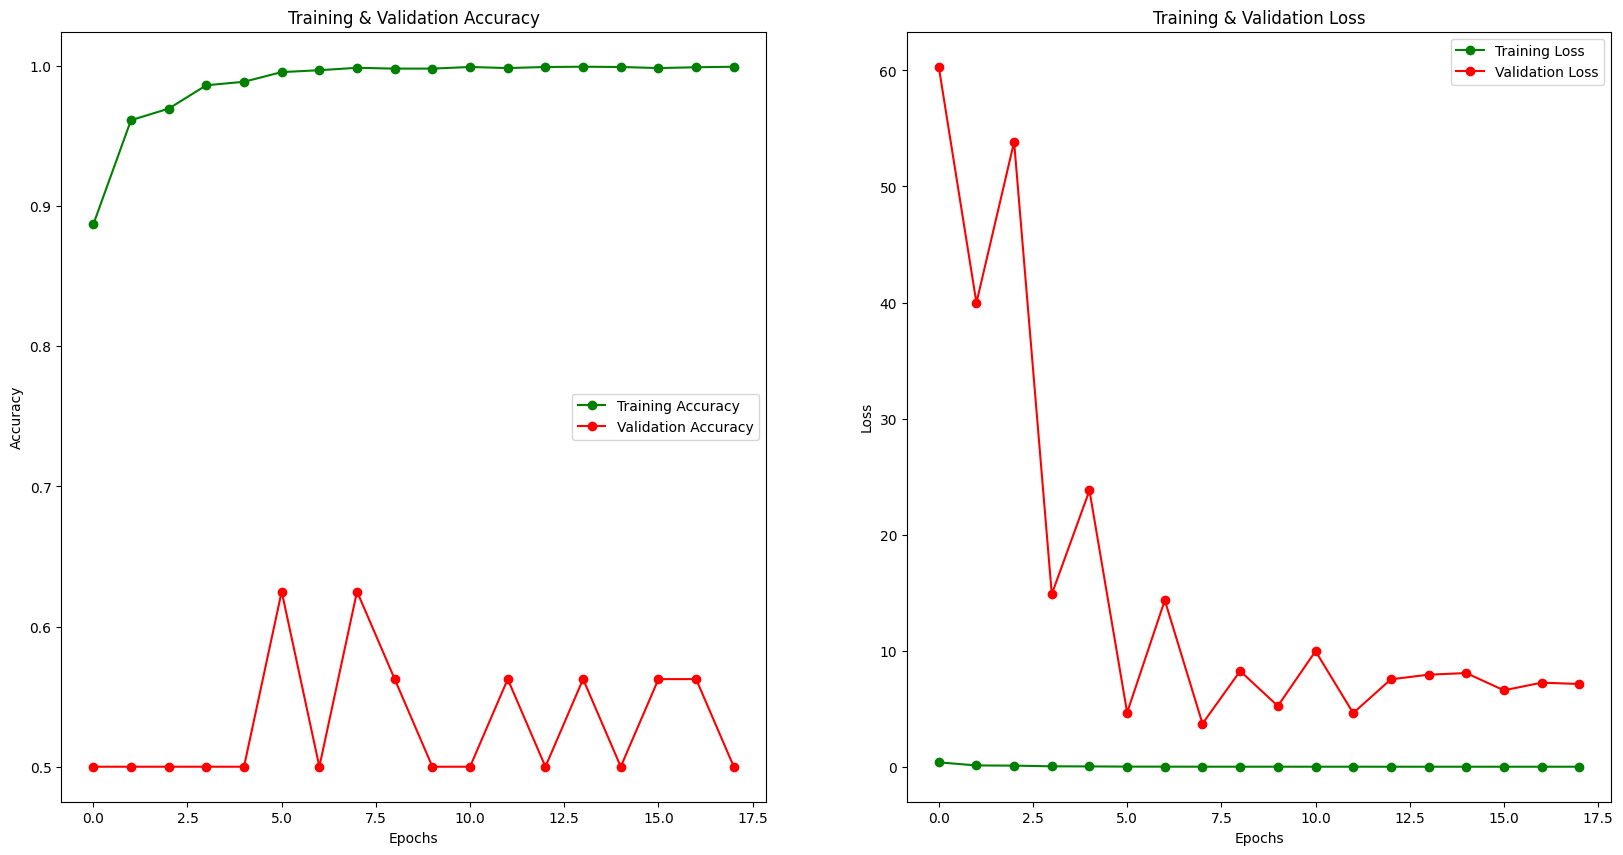

In [19]:
epochs = [i for i in range(18)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')


ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

In [20]:
predictions = (model.predict(x_test) > 0.5).astype('int32')
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [21]:
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.71      1.00      0.83       390
   Normal (Class 1)       0.99      0.32      0.48       234

           accuracy                           0.74       624
          macro avg       0.85      0.66      0.65       624
       weighted avg       0.81      0.74      0.70       624



In [22]:
cm = confusion_matrix(y_test,predictions)

In [23]:
cm

array([[389,   1],
       [160,  74]])

In [24]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]


Some Correctly Predicted Classes **bold text**

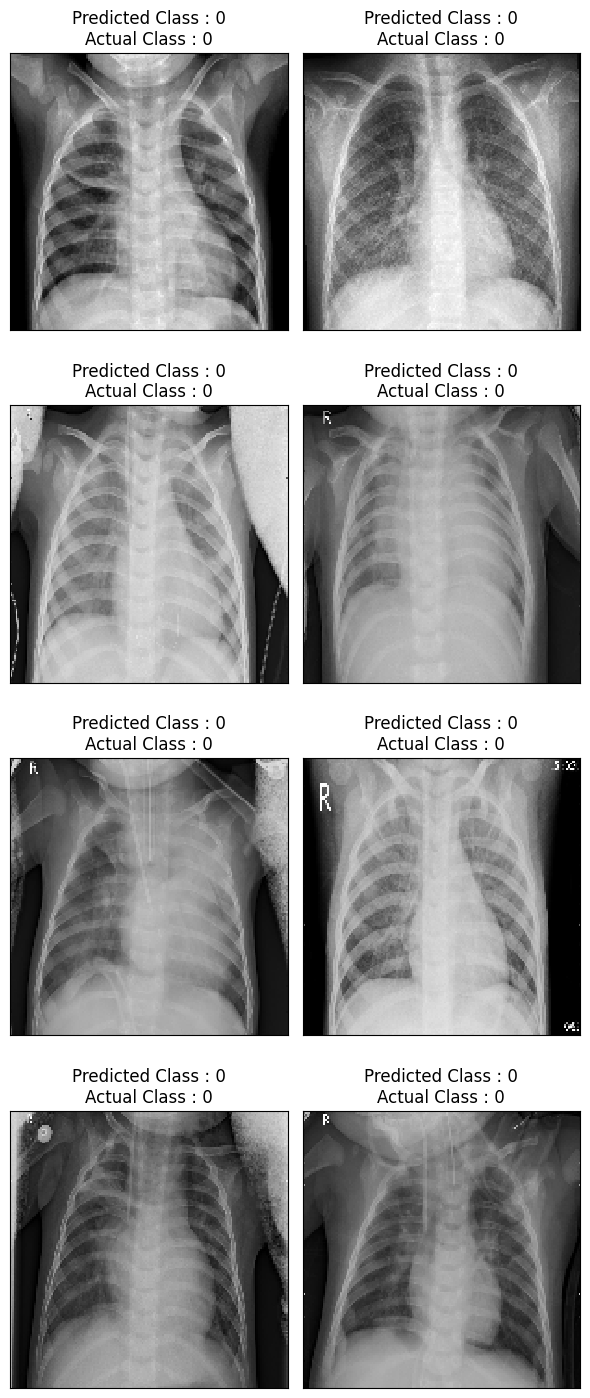

In [25]:
i = 0
plt.figure(figsize=(6,15))
for c in correct[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150), cmap='gray', interpolation='none')
  plt.title(f"Predicted Class : {predictions[c]}\nActual Class : {y_test[c]}")
  plt.tight_layout()
  i += 1

**Some Incorrectly predicted Classes**

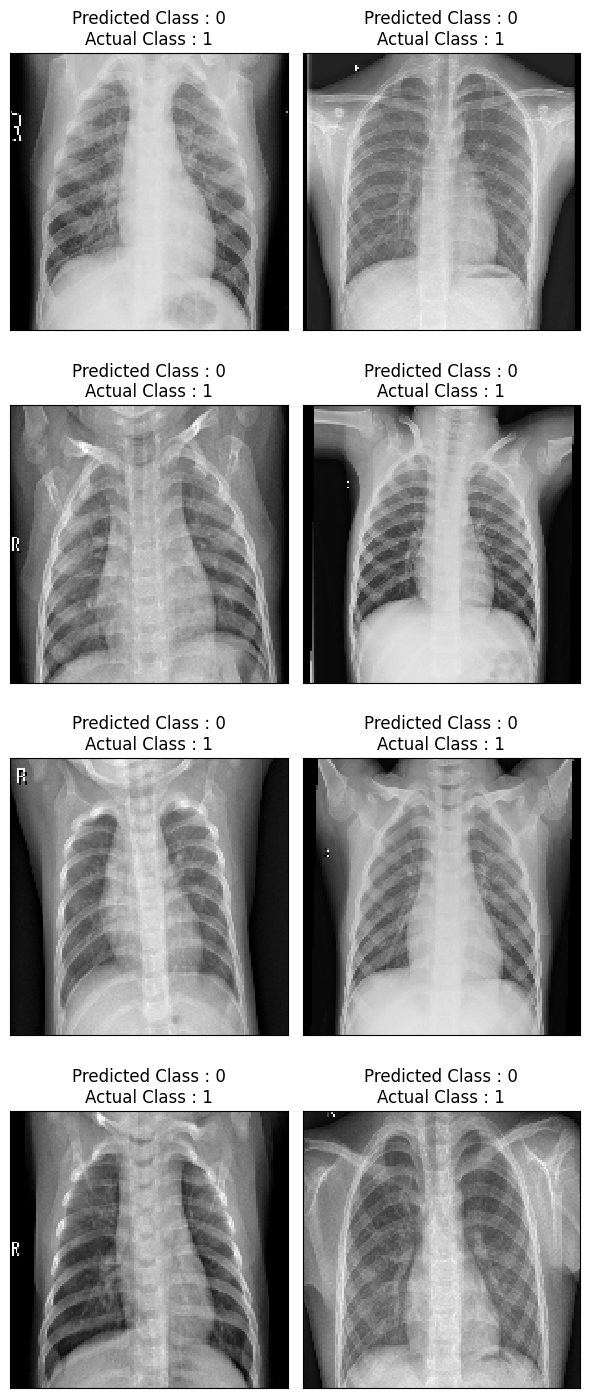

In [26]:
i = 0
plt.figure(figsize=(6,15))
for c in incorrect[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150), cmap='gray', interpolation='none')
  plt.title(f"Predicted Class : {predictions[c]}\nActual Class : {y_test[c]}")
  plt.tight_layout()
  i += 1